In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

def channel_shuffle(x, groups):
    batchsize, num_channels, T = x.data.size()
    channels_per_group = num_channels // groups
    x = x.view(batchsize, groups, 
        channels_per_group, T)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batchsize, -1, T)
    return x

def pool_per_T(T,L):
    if T>=512:
        pool_num = 4
    elif T>=256:
        pool_num = 3
    elif T>=128:
        pool_num = 2
    elif T>=64:
        pool_num = 1
    else:
        return []

    split = [int(np.floor(L / (pool_num+1))) for _ in range(pool_num+1)]
    residual = L - sum(split)
    for i in range(residual):
        split[i] += 1
    split.pop()

    pool_idx = []
    pidx = -1
    for i in split:
        pidx += i
        pool_idx.append(pidx)
    return pool_idx


class ConvLayer(nn.Module):
    def __init__(self, i_nc, o_nc, L, T, pool):
        super(ConvLayer, self).__init__()
        self.L = L
        self.pool = pool

        # local temperol convolution
        self.gconv = nn.Conv1d(i_nc, o_nc, kernel_size=5, padding='same', bias=False, groups=L)
        #self.bn = nn.BatchNorm1d(o_nc)

        # temporal glance convolution
        self.tgconv = nn.Conv1d(o_nc, o_nc//L, kernel_size=T)
        
    def forward(self, x):
        _,_,t = x.size()
        if self.pool:
            x = F.adaptive_max_pool1d(x,t//2)
        l_feat = self.gconv(x)
        #l_feat = F.relu_(self.bn(x))
        #l_feat = channel_shuffle(x, self.L)
        g_feat = self.tgconv(l_feat)
        return l_feat, g_feat

class HTAggNet(nn.Module):
    def __init__(self, nc_input, n_classes, segment_size, L):

        super(HTAggNet, self).__init__()
        T = segment_size
        nc_o = 64
        if nc_input > 64:
            nc_o *= 2
            pre_mul = 1
        else:
            pre_mul = 0
        self.L = L

        self.stem = nn.Conv1d(nc_input, nc_o, 5, padding='same')   
        #self.bn = nn.BatchNorm1d(nc_o)     
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        pool_idx = pool_per_T(T,L)

        T = math.ceil(T / 2)
        nc_i = nc_o

        out_channel_num = []

        self.layers = nn.ModuleList()
        for i in range(self.L):
            if i in pool_idx:
                pool = True
                T = T // 2
                if pre_mul > 0:
                    pre_mul -=1
                else:
                    nc_o *= 2
            else:
                pool = False
            self.layers.append(ConvLayer(nc_i, nc_o, self.L, T, pool))
            nc_i = nc_o
            out_channel_num.append(nc_o//L)
        
        self.fc = nn.Linear(sum(out_channel_num), n_classes)
    
    def forward(self, x):
        #x = self.bn(self.stem(x))
        x = self.stem(x)
        x = self.maxpool(x)

        #fm = []
        out = []
        for block in self.layers:
            x, g_feat = block(x)
            #fm.append(x)
            out.append(g_feat)
        
        out = torch.cat(out, dim=1)

        out = out.view(out.size(0), -1)

        logits = self.fc(out)

        return F.log_softmax(logits, dim=1)#, fm

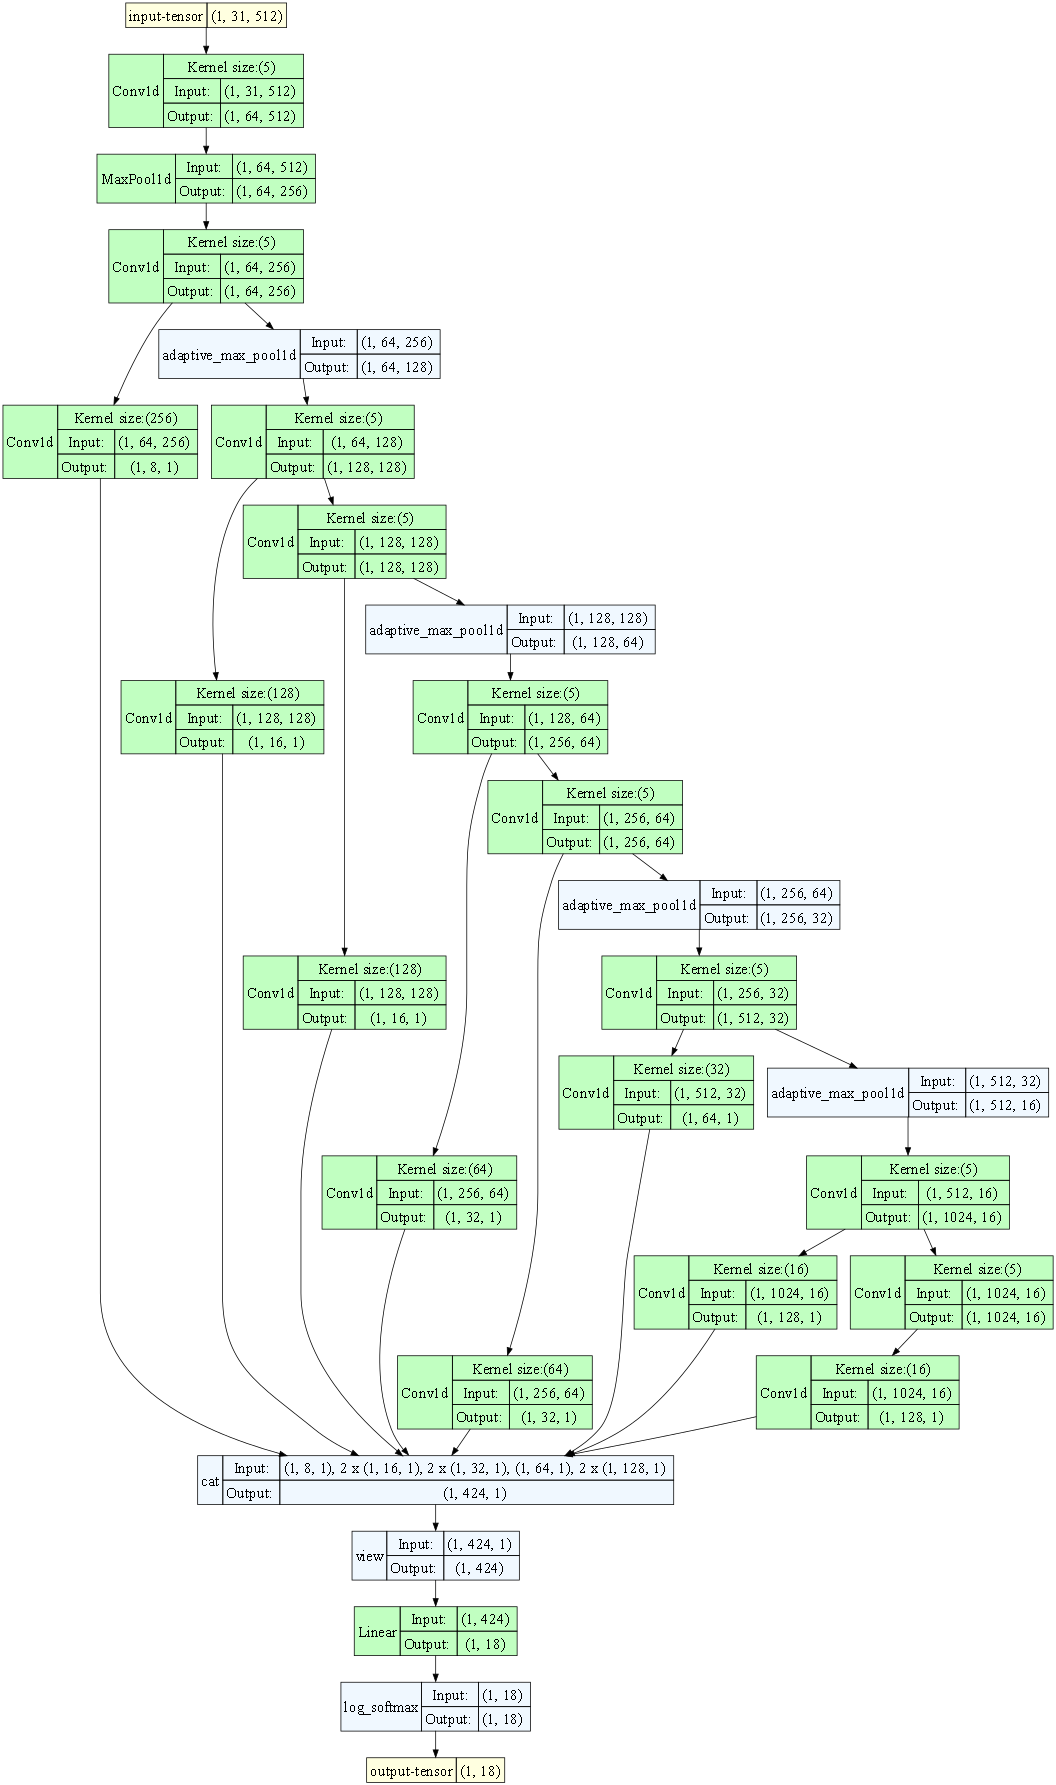

In [13]:
from utils import data_info
# import os
# os.environ["PATH"]+=os.pathsep+'C:\\Program Files\\Graphviz\\bin'
import graphviz
graphviz.set_jupyter_format('png')

#dataset = "UCI_HAR"
#dataset = "UniMiB-SHAR"
#dataset = "OPPORTUNITY"
dataset = "PAMAP2"
#dataset = "DSADS"
#dataset = "KU-HAR"
#dataset = "REALDISP"


input_nc, segment_size, class_num = data_info(dataset)

net = HTAggNet(input_nc, class_num, segment_size, 8)

from torchview import draw_graph

model_graph = draw_graph(net, input_size=(1, input_nc, segment_size), strict=False, save_graph=True, filename="MALANet", expand_nested=False)
#model_graph = draw_graph(net, input_size=(1, input_nc, segment_size), strict=False, save_graph=True, filename="HTConvNet", expand_nested=False)
model_graph.visual_graph